In [3]:
import warnings
warnings.filterwarnings("ignore")

In [80]:
# data
import pandas as pd
import numpy as np
from datetime import datetime
from math import ceil

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# processing
from sklearn.impute import KNNImputer
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.base import clone

# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

# clustering models
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# metrics
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples

# multidimensional visualization methods
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
sns.set()
%matplotlib inline

In [5]:
#Always display all columns
pd.set_option('display.max_columns', None)

# Data Understanding: 

### Data Exploration
- view the original dataset
- outliers
- null values

In [87]:
# read the dataset
df_full = pd.read_csv('H2.csv')

In [88]:
#traintest split here
X = df_full.drop('IsCanceled', axis = 1)
y = df_full['IsCanceled']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0, stratify = y, shuffle = True)

In [89]:
df=pd.concat([X_train,y_train], axis=1)

In [90]:
# create a copy of the original df for preprocessing
df_backup = df.copy()

In [91]:
# first rows - view the structure
df.head(25)

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsCanceled
12550,32,2016,June,24,8,0,4,2,2.0,0,BB,USA,Online TA,TA/TO,0,0,0,F,F,0,No Deposit,9,NULL,0,Transient,191.70,0,0,Canceled,2016-05-30,1
11947,63,2016,May,22,28,2,1,2,0.0,0,BB,CHN,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,140.40,0,0,No-Show,2016-05-28,1
72945,204,2017,May,22,28,2,2,2,0.0,0,BB,NLD,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,133.65,0,1,Check-Out,2017-06-01,0
57016,12,2016,September,38,11,1,0,1,0.0,0,BB,CHN,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,295,NULL,0,Transient-Party,85.00,0,1,Check-Out,2016-09-12,0
17539,447,2016,September,40,29,0,1,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1,NULL,0,Transient,59.00,0,0,Canceled,2015-10-21,1
27709,99,2017,May,18,6,2,6,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,139.50,0,0,Canceled,2017-02-04,1
6938,30,2016,February,6,2,1,5,2,2.0,0,BB,BRA,Online TA,TA/TO,0,0,0,B,B,0,No Deposit,9,NULL,0,Transient,139.05,0,0,Canceled,2016-01-03,1
3822,87,2015,September,39,25,2,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1,NULL,0,Transient,170.00,0,0,Canceled,2015-09-09,1
67399,57,2017,March,10,8,1,4,2,0.0,0,SC,NLD,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,74.80,0,0,Check-Out,2017-03-13,0
6094,17,2015,December,51,18,0,2,2,0.0,0,BB,ITA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,87.00,0,1,Canceled,2015-12-14,1


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55531 entries, 12550 to 43777
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LeadTime                     55531 non-null  int64  
 1   ArrivalDateYear              55531 non-null  int64  
 2   ArrivalDateMonth             55531 non-null  object 
 3   ArrivalDateWeekNumber        55531 non-null  int64  
 4   ArrivalDateDayOfMonth        55531 non-null  int64  
 5   StaysInWeekendNights         55531 non-null  int64  
 6   StaysInWeekNights            55531 non-null  int64  
 7   Adults                       55531 non-null  int64  
 8   Children                     55529 non-null  float64
 9   Babies                       55531 non-null  int64  
 10  Meal                         55531 non-null  object 
 11  Country                      55514 non-null  object 
 12  MarketSegment                55531 non-null  object 
 13  Distribution

In [93]:
'''
weeks of the year has one value of 53
babies has an outlier of 9 and 10
days in waiting list has outliers
NULL text string is inplace of nans often
we need to do some transformations on the date variables
do we need the company or can we make it a binary variable
consider changing Babies to binary variable
lots of categorical variables to check 
possible created feature: percentage of weekend nights in the stay
consider logADR depending on the distribution
4 nans in Children - fill with 0
we have a few duplicated values
'''

'\nweeks of the year has one value of 53\nbabies has an outlier of 9 and 10\ndays in waiting list has outliers\nNULL text string is inplace of nans often\nwe need to do some transformations on the date variables\ndo we need the company or can we make it a binary variable\nconsider changing Babies to binary variable\nlots of categorical variables to check \npossible created feature: percentage of weekend nights in the stay\nconsider logADR depending on the distribution\n4 nans in Children - fill with 0\nwe have a few duplicated values\n'

In [94]:
# the dataset has null values ('Children' and 'Country')
df[df.Children.isna()]

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsCanceled
607,1,2015,August,32,5,0,2,2,NaN,0,BB,PRT,Direct,Undefined,0,0,0,B,B,0,No Deposit,14,NULL,0,Transient-Party,12.0,0,1,Canceled,2015-08-04,1
619,1,2015,August,32,5,0,2,3,NaN,0,BB,PRT,Undefined,Undefined,0,0,0,B,B,0,No Deposit,NULL,NULL,0,Transient-Party,18.0,0,2,Canceled,2015-08-04,1


In [95]:
#Company: ID of the company/entity that made the booking or responsible for paying the booking
#Missing values may indicate that the reservation was made by an individual

In [96]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LeadTime,55531.0,109.579874,110.742749,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,55531.0,2016.175776,0.699583,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateWeekNumber,55531.0,27.151429,13.398175,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,55531.0,15.767553,8.717110,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,55531.0,0.796672,0.886532,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,55531.0,2.183393,1.463527,0.0,1.0,2.0,3.0,41.0
Adults,55531.0,1.852605,0.507934,0.0,2.0,2.0,2.0,4.0
Children,55529.0,0.090511,0.371392,0.0,0.0,0.0,0.0,3.0
Babies,55531.0,0.004880,0.081592,0.0,0.0,0.0,0.0,10.0
IsRepeatedGuest,55531.0,0.025139,0.156549,0.0,0.0,0.0,0.0,1.0


In [97]:
df.Agent.nunique()
#There are 215 unique travel agency that made bookings

215

In [98]:
df.Company.nunique()
#There are 189 unique companies that made bookings

189

In [99]:
df.Country.nunique()
#Bookings were made from 151 different countries

151

In [100]:
df.MarketSegment.unique()

array(['Online TA', 'Offline TA/TO', 'Groups', 'Direct', 'Corporate',
       'Complementary', 'Aviation', 'Undefined'], dtype=object)

In [101]:
df.select_dtypes(exclude=np.number).columns

Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
       'DepositType', 'Agent', 'Company', 'CustomerType', 'ReservationStatus',
       'ReservationStatusDate'],
      dtype='object')

In [102]:
df.duplicated().value_counts()

False    38825
True     16706
dtype: int64

In [103]:
#there were duplicated observations. 
df[(df.duplicated()==True)&(df.LeadTime==27)]

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsCanceled
4068,27,2015,September,40,30,0,2,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,64,NULL,21,Transient,108.00,0,0,Canceled,2015-09-24,1
4073,27,2015,September,40,30,0,2,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,64,NULL,21,Transient,108.00,0,0,Canceled,2015-09-24,1
10813,27,2016,May,20,10,0,3,2,0.0,0,BB,TJK,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,141.00,0,0,Canceled,2016-04-13,1
12580,27,2016,June,24,9,0,1,2,0.0,0,BB,PRT,Offline TA/TO,Corporate,0,0,0,A,A,0,No Deposit,191,NULL,0,Transient-Party,120.00,0,0,Canceled,2016-06-02,1
446,27,2015,July,31,27,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1,NULL,0,Transient-Party,62.00,0,0,Canceled,2015-07-02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13577,27,2016,June,27,26,2,1,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,152.67,0,0,Canceled,2016-05-31,1
461,27,2015,July,31,27,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1,NULL,0,Transient-Party,62.00,0,0,Canceled,2015-07-02,1
57804,27,2016,September,39,20,0,1,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,288,NULL,0,Transient-Party,95.00,0,0,Check-Out,2016-09-21,0
4051,27,2015,September,40,30,0,2,2,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,64,NULL,21,Transient,108.00,0,0,Canceled,2015-09-24,1


In [104]:
# Checking for the balance of the dataset: 
df['IsCanceled'].value_counts(normalize=True)*100

0    58.273757
1    41.726243
Name: IsCanceled, dtype: float64

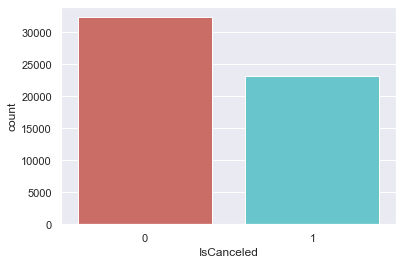

In [105]:
sns.countplot(x='IsCanceled', data=df, palette='hls')
plt.show()

In [106]:
#It is a relatively balanced dataset

### Data Visualization: 

In [137]:
#Define metric and non metric features: 
non_metric_features = ["Agent", "AssignedRoomType", "Company", "Country", "CustomerType", "DepositType", "DistributionChannel", 
                       "IsRepeatedGuest", "MarketSegment", "Meal", "ReservationStatus","ReservationStatusDate","ReservedRoomType", "IsCanceled"]
metric_features=[i for i in list(df.columns) if i not in non_metric_features]

non_metric_features_without_target = ["Agent", "AssignedRoomType", "Company", "Country", "CustomerType", "DepositType", "DistributionChannel", 
                       "IsRepeatedGuest", "MarketSegment", "Meal", "ReservationStatus","ReservationStatusDate","ReservedRoomType"]

In [97]:
# Are date variables considered categorical or numerical?

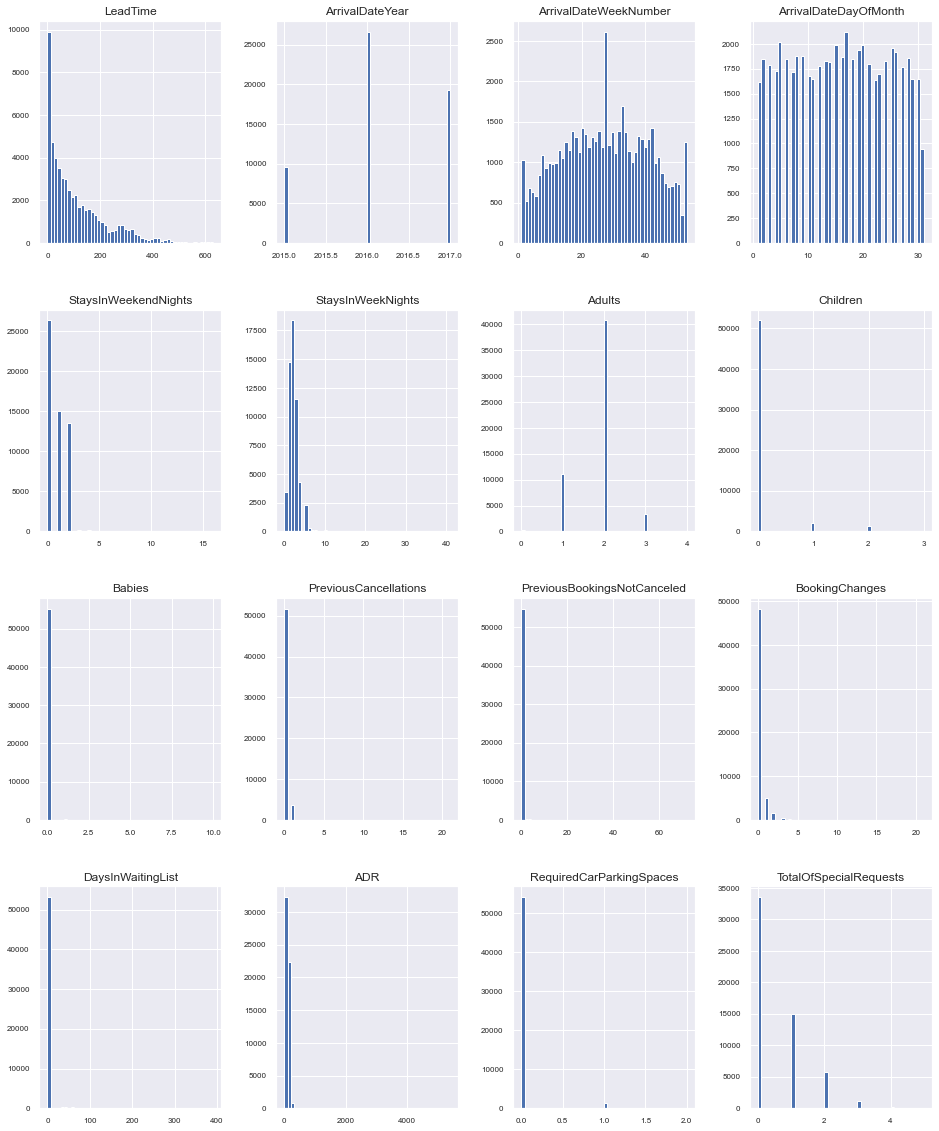

In [98]:
df[metric_features].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

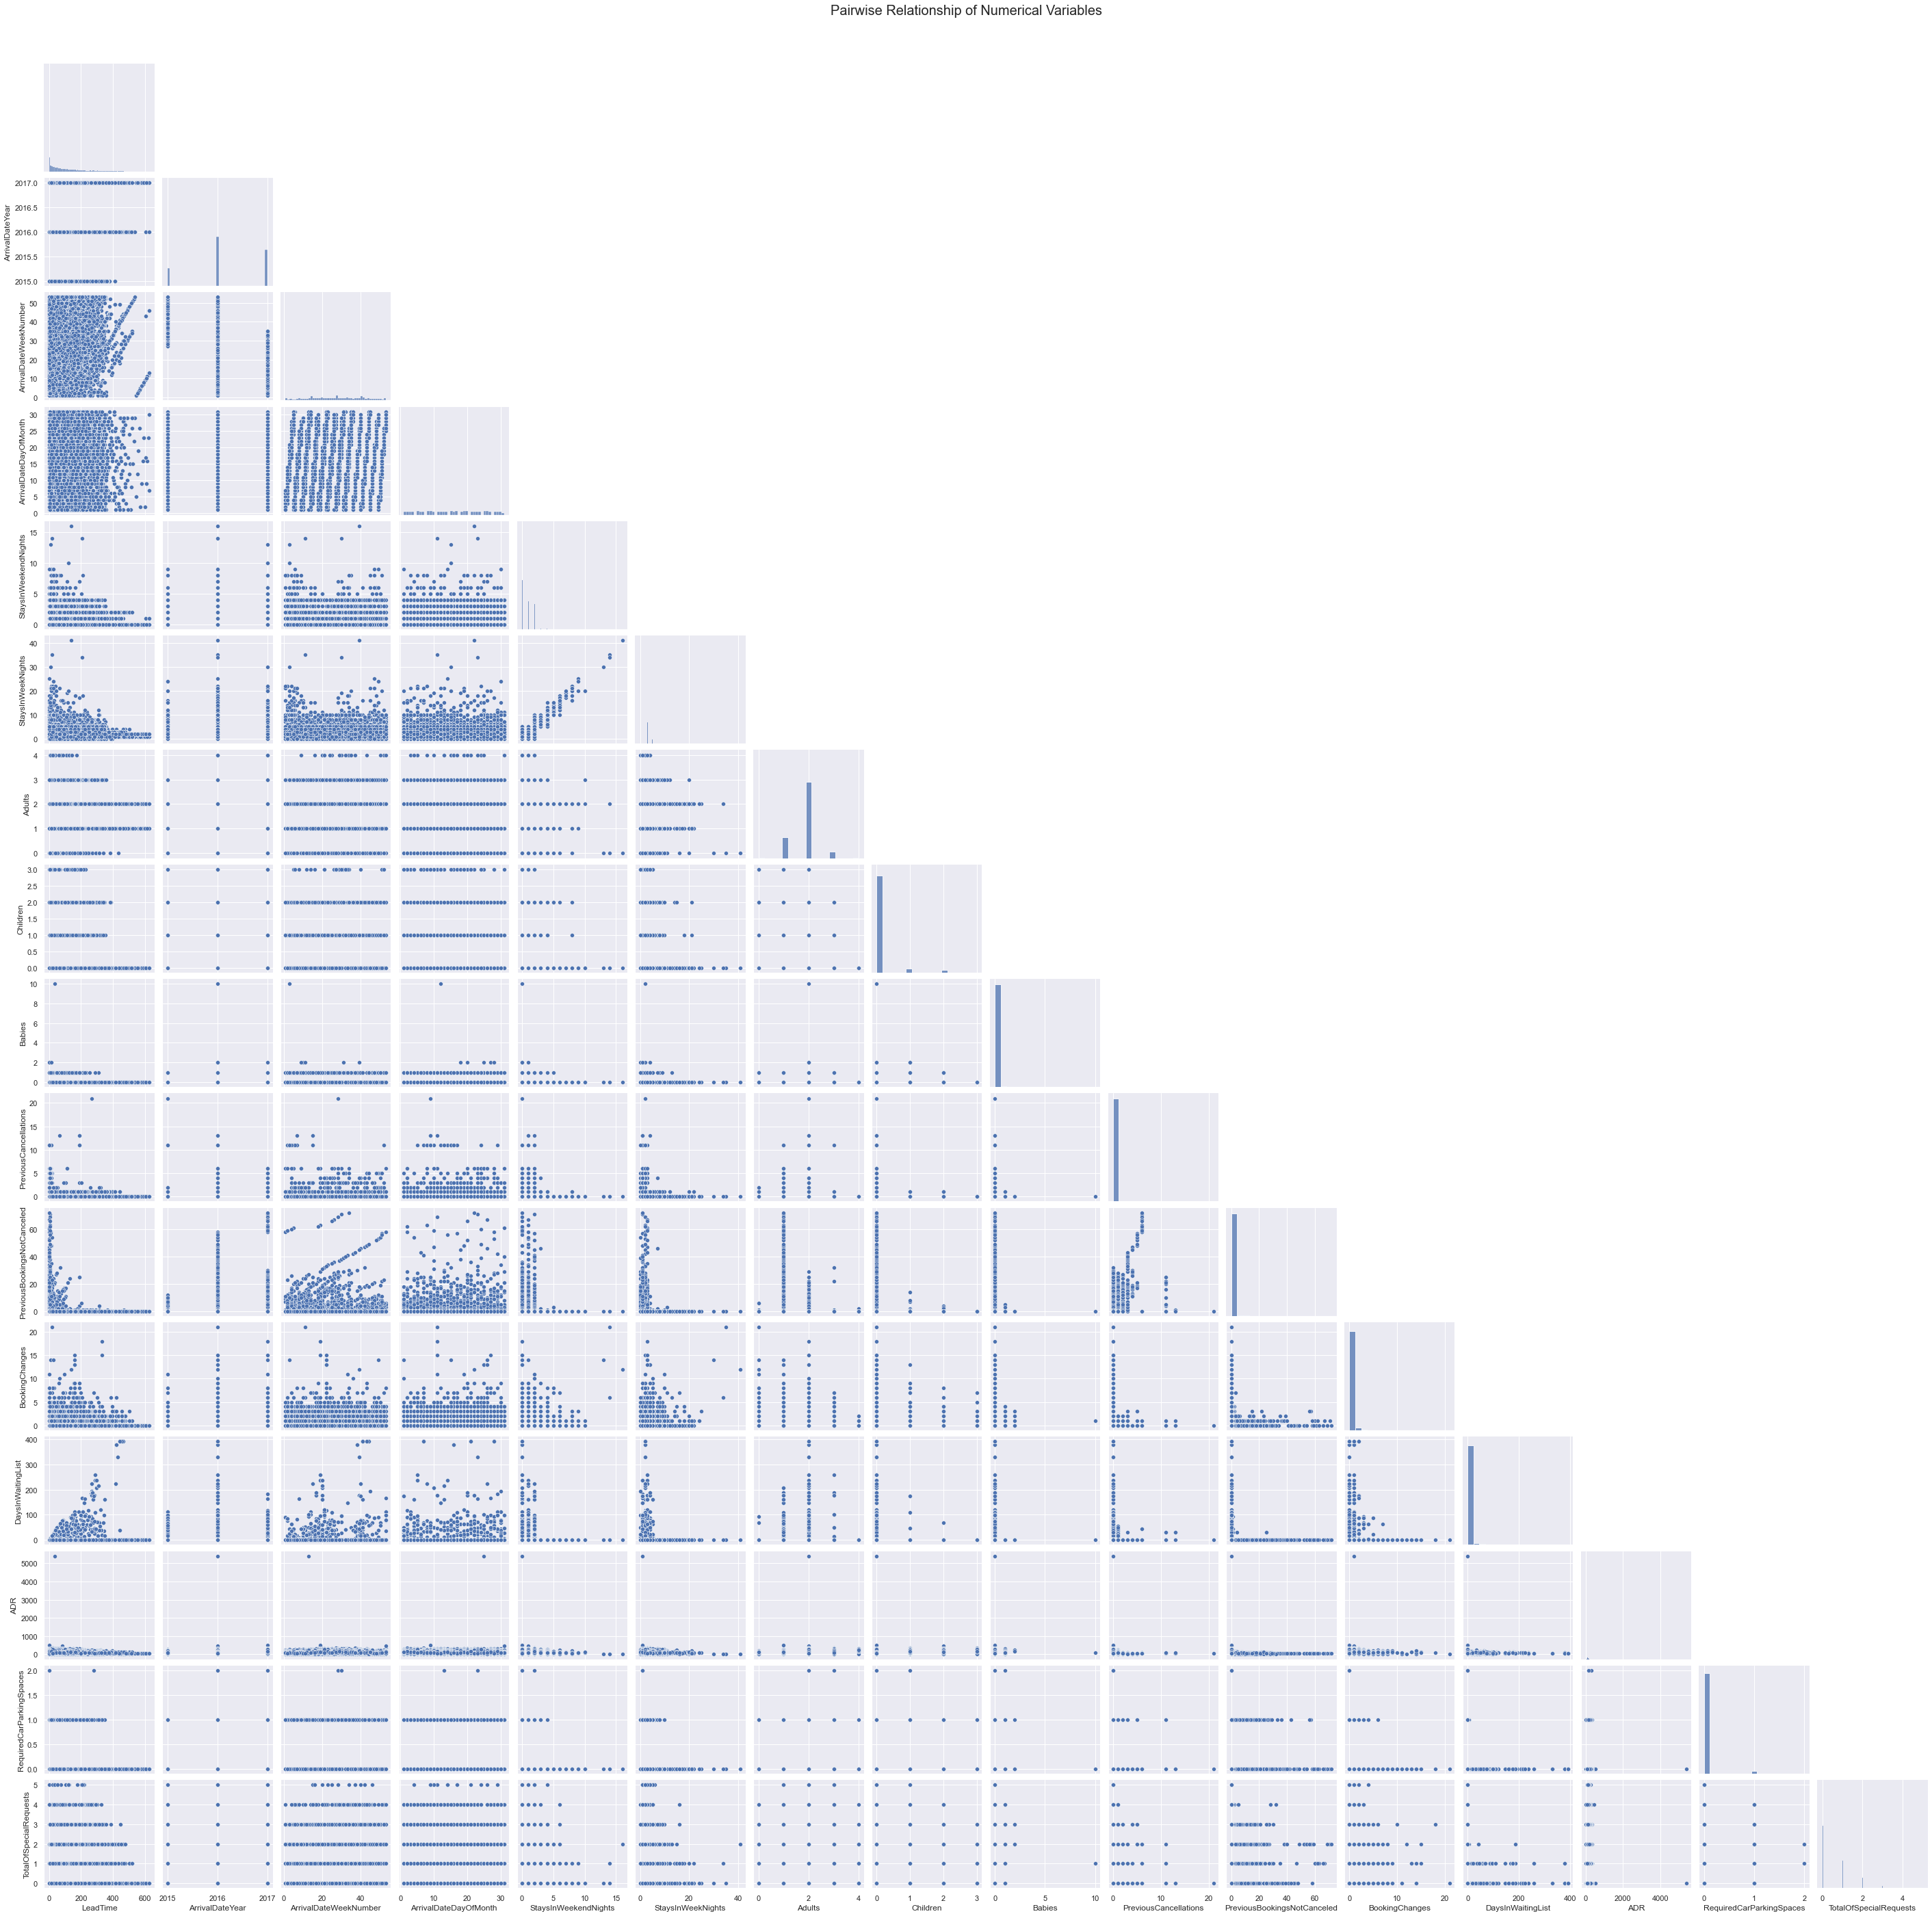

In [99]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(df[metric_features], diag_kind="hist", corner=True)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

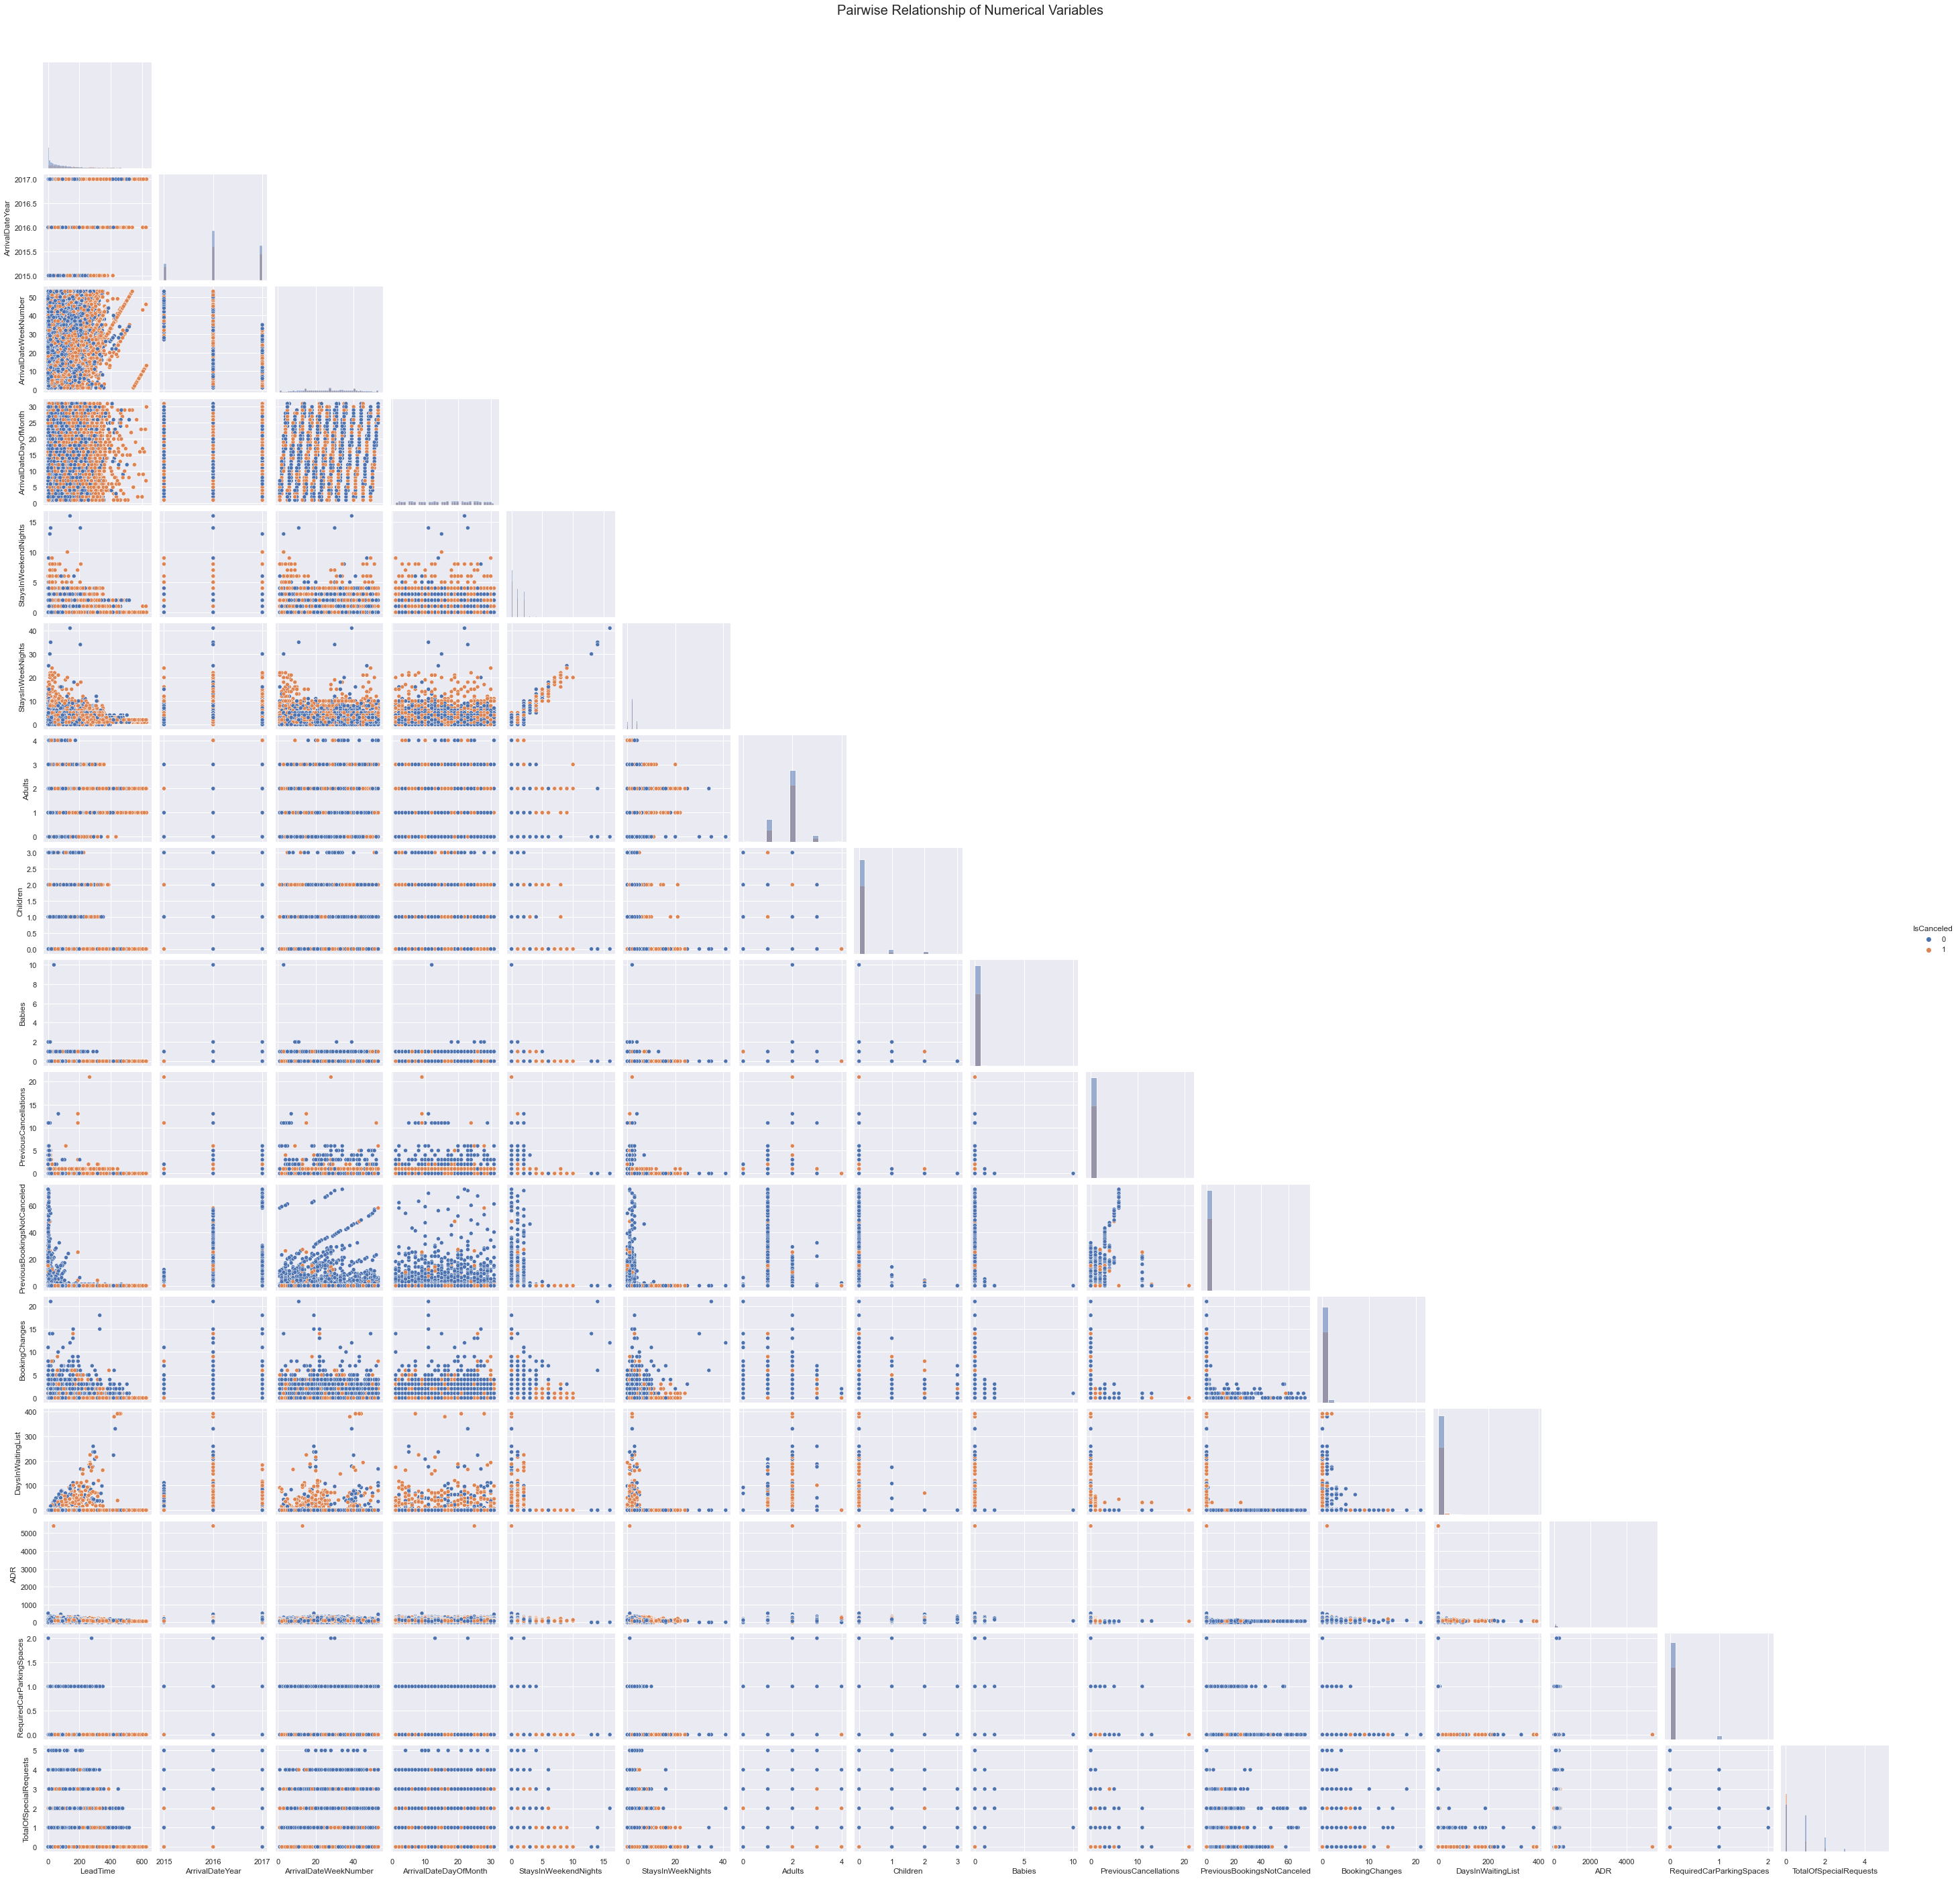

In [14]:
#Do not run (taking too long or bugged)

#Pairwise Relationship of Numerical Variables
sns.set()

##Setting pairplot
sns.pairplot(df[metric_features + ['IsCanceled']], diag_kind="hist", corner=True, hue='IsCanceled')

## Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)
plt.show()

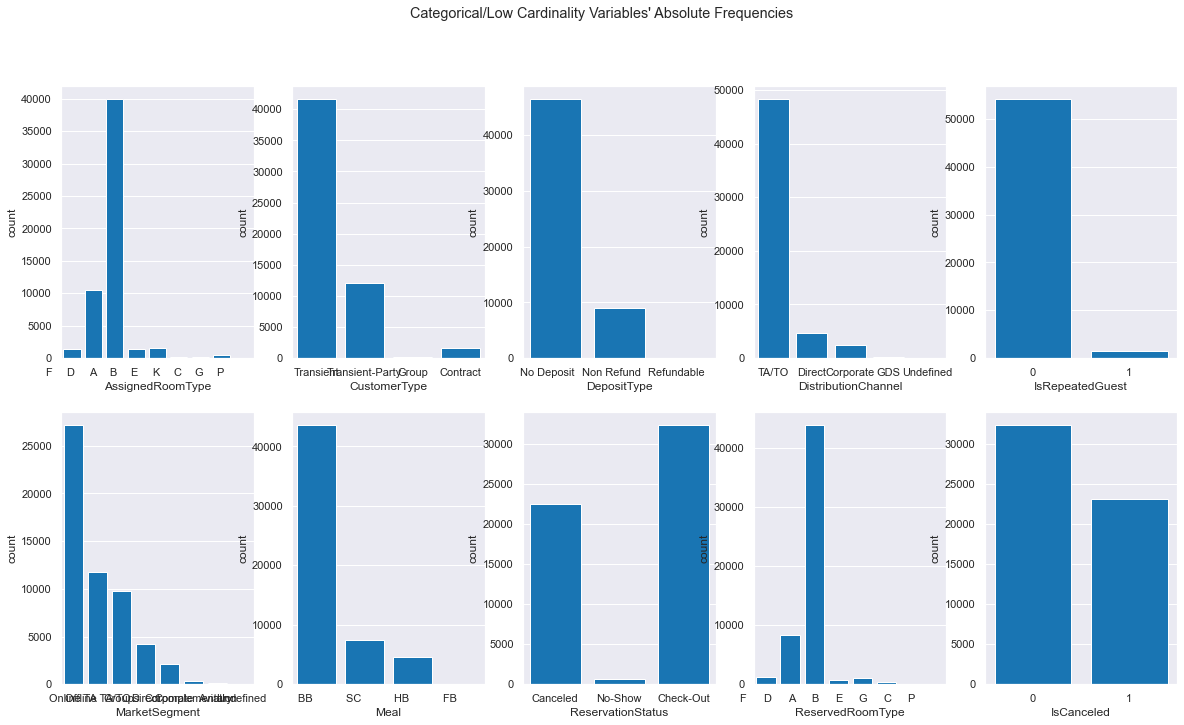

In [17]:
#Do not run
# All Non-Metric Variables' Absolute Frequencies
sns.set()

## Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(5), figsize=(20, 11))

## Plot data
## Iterate across axes objects and associate each bar plot:
for ax, feat in zip(axes.flatten(), ["AssignedRoomType", "CustomerType", "DepositType", "DistributionChannel", 
                       "IsRepeatedGuest", "MarketSegment", "Meal", "ReservationStatus","ReservedRoomType", "IsCanceled"]): 
    sns.countplot(df[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)
plt.show()

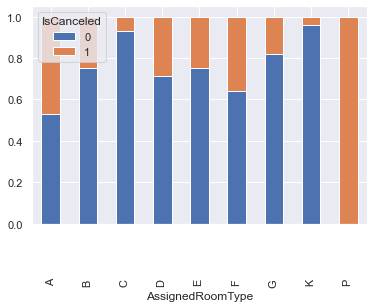

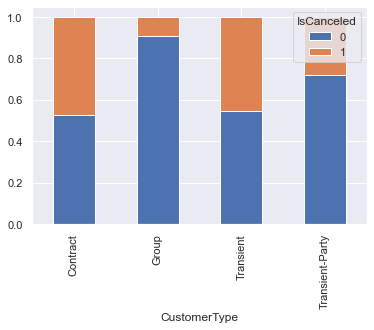

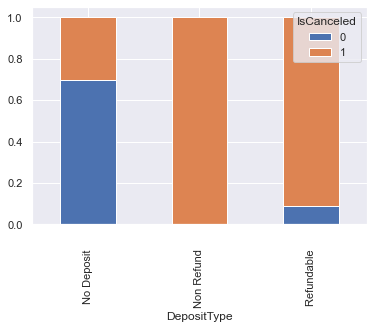

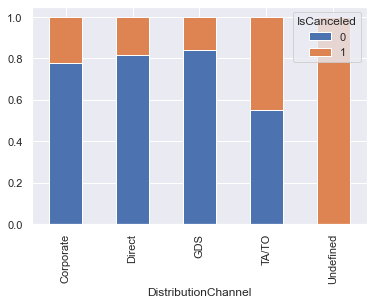

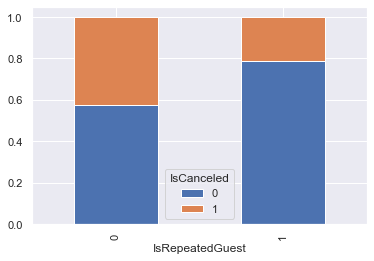

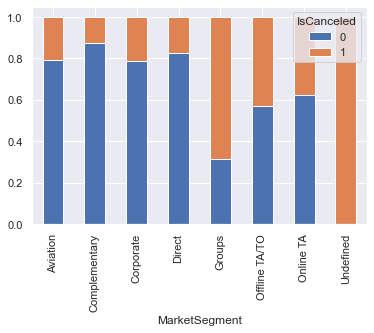

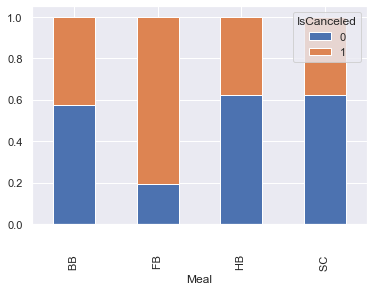

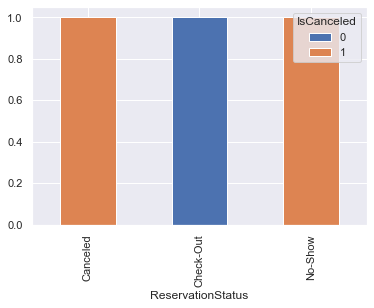

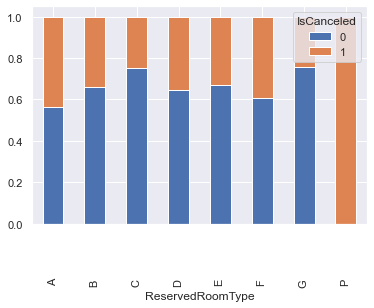

In [16]:
#Do not run
# Iterate across axes objects and associate each bar plot:
for ax, feat in zip(axes.flatten(), ["AssignedRoomType", "CustomerType", "DepositType", "DistributionChannel", 
                       "IsRepeatedGuest", "MarketSegment", "Meal", "ReservationStatus","ReservedRoomType"]): 
    table=pd.crosstab(df[feat],df.IsCanceled)
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

In [18]:
#It seems all categorical variables are important in modeling

# Data Preparation: 


### Remove Outliers

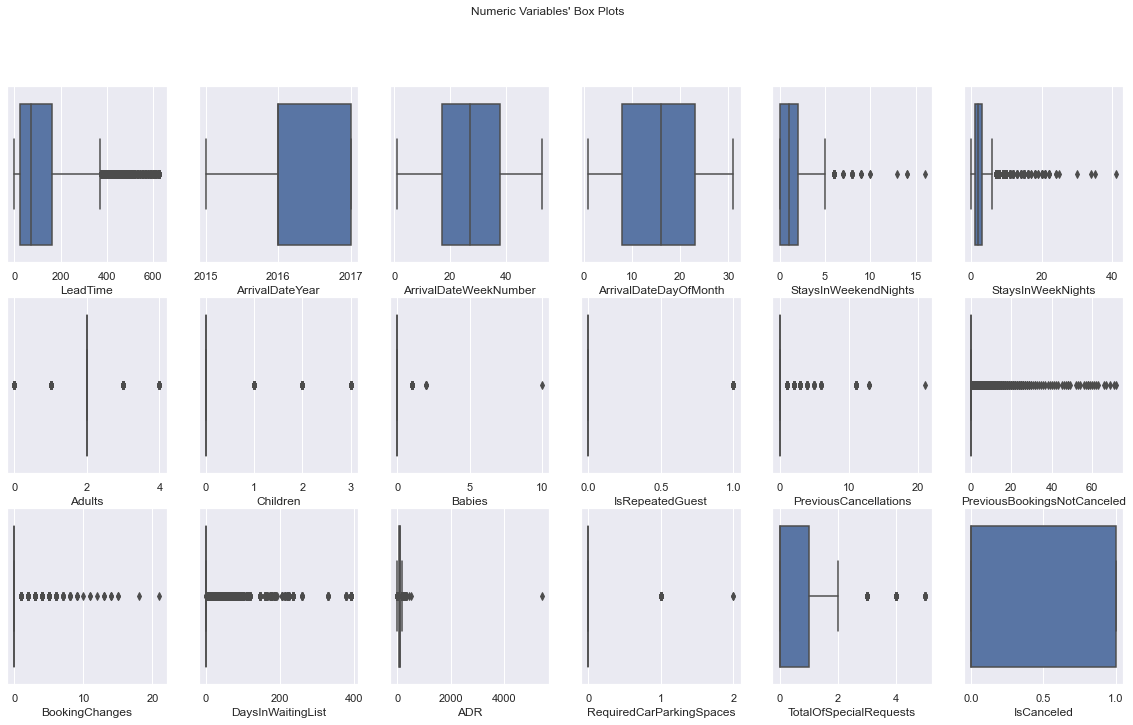

In [19]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.boxplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [104]:
'''manual outlier removal:
Babies
ADR
DaysInWaitingList'''

'manual outlier removal:\nBabies\nADR\nDaysInWaitingList'

In [108]:
filters1 = (
    (df['Babies']<=5)
    &
    (df['ADR']<=2000)
    &
    (df['DaysInWaitingList']<=300)
)

df = df[filters1]

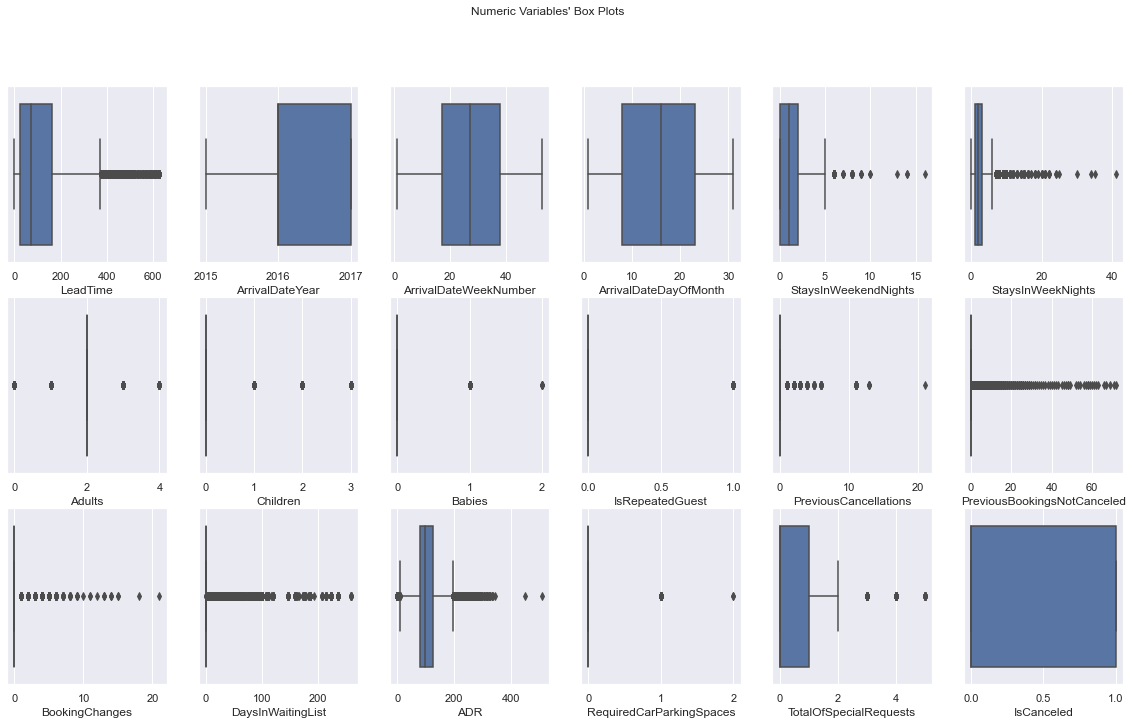

In [109]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.boxplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

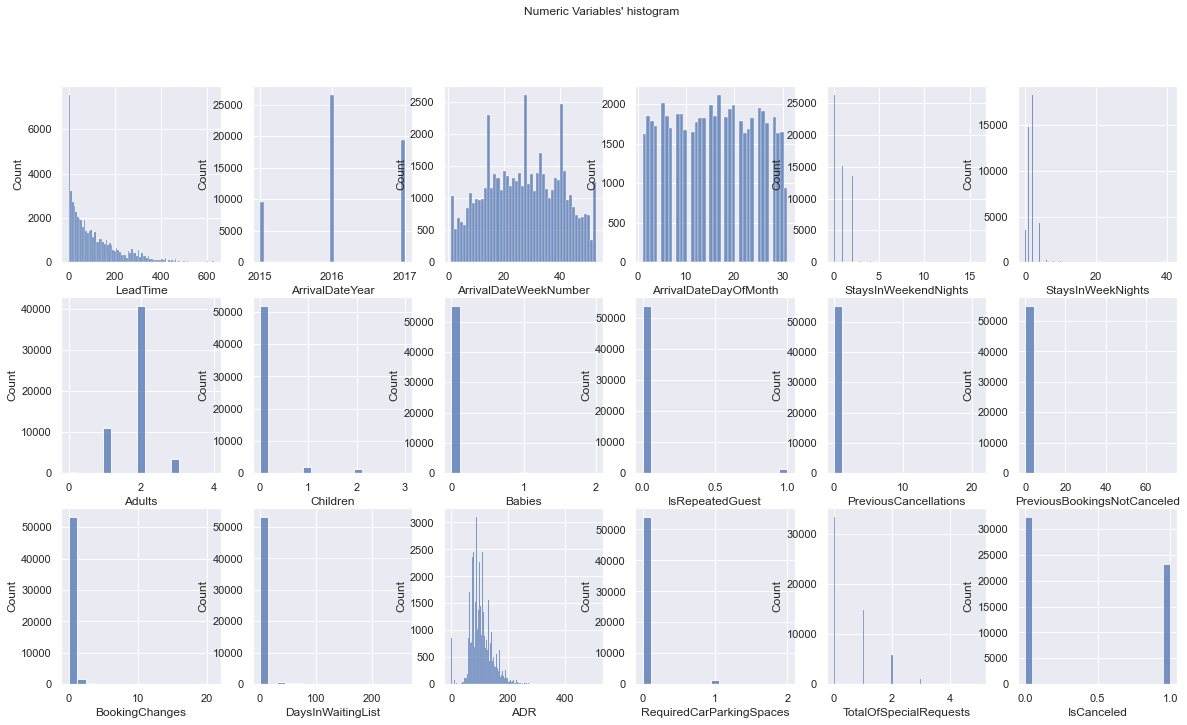

In [107]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.histplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' histogram"

plt.suptitle(title)

plt.show()

## Fill Missing Values

In [108]:
#check for =="NULL" as well as .isna()
df.Children.fillna(0, inplace = True)

In [22]:
df.replace('       NULL',np.nan, inplace=True)
df.replace('NULL',np.nan, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55471 entries, 12550 to 43777
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LeadTime                     55471 non-null  int64  
 1   ArrivalDateYear              55471 non-null  int64  
 2   ArrivalDateMonth             55471 non-null  object 
 3   ArrivalDateWeekNumber        55471 non-null  int64  
 4   ArrivalDateDayOfMonth        55471 non-null  int64  
 5   StaysInWeekendNights         55471 non-null  int64  
 6   StaysInWeekNights            55471 non-null  int64  
 7   Adults                       55471 non-null  int64  
 8   Children                     55469 non-null  float64
 9   Babies                       55471 non-null  int64  
 10  Meal                         55471 non-null  object 
 11  Country                      55454 non-null  object 
 12  MarketSegment                55471 non-null  object 
 13  Distribution

In [24]:
df.isnull().sum()

LeadTime                           0
ArrivalDateYear                    0
ArrivalDateMonth                   0
ArrivalDateWeekNumber              0
ArrivalDateDayOfMonth              0
StaysInWeekendNights               0
StaysInWeekNights                  0
Adults                             0
Children                           2
Babies                             0
Meal                               0
Country                           17
MarketSegment                      0
DistributionChannel                0
IsRepeatedGuest                    0
PreviousCancellations              0
PreviousBookingsNotCanceled        0
ReservedRoomType                   0
AssignedRoomType                   0
BookingChanges                     0
DepositType                        0
Agent                           5688
Company                        52860
DaysInWaitingList                  0
CustomerType                       0
ADR                                0
RequiredCarParkingSpaces           0
T

In [30]:
# Missing values in the variables agent and company indicate that the reservation was made 
#by an individual rather than by a travel agency or a comapny
#And given that these 2 variables have many unique values(+100),We thought about changing them
#to represent 1 if an agency or a company made the reservation and 0 otherwise

In [110]:
df['Agent'].fillna(0, inplace=True)
df['Company'].fillna(0, inplace=True)

In [111]:
df.loc[df['Agent']!=0, 'Agent'] = 1
df.loc[df['Company']!=0, 'Company'] = 1

In [112]:
#Fill missing values with "Unknown", since we do not have the information (was probably not informed during booking)
df['Country'].fillna("Unknown", inplace=True)
df['Children'].fillna(0, inplace=True)

In [118]:
df.isnull().sum()

LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
Agent                          0
Company                        0
DaysInWaitingList              0
CustomerType                   0
ADR                            0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
ReservationStatusDate          0
IsCanceled

### Change data types:

In [59]:
df.dtypes

LeadTime                                int64
ArrivalDateYear                         int64
ArrivalDateMonth                       object
ArrivalDateWeekNumber                   int64
ArrivalDateDayOfMonth                   int64
StaysInWeekendNights                    int64
StaysInWeekNights                       int64
Adults                                  int64
Children                                int32
Babies                                  int64
Meal                                   object
Country                                object
MarketSegment                          object
DistributionChannel                    object
IsRepeatedGuest                         int64
PreviousCancellations                   int64
PreviousBookingsNotCanceled             int64
ReservedRoomType                       object
AssignedRoomType                       object
BookingChanges                          int64
DepositType                            object
Agent                             

In [60]:
#Change ReservationStatusDate to date
df['ReservationStatusDate'] = pd.to_datetime(df['ReservationStatusDate'])

#Change Children from float to int
df['Children'] = df['Children'].astype(int)

In [61]:
df.dtypes

LeadTime                                int64
ArrivalDateYear                         int64
ArrivalDateMonth                       object
ArrivalDateWeekNumber                   int64
ArrivalDateDayOfMonth                   int64
StaysInWeekendNights                    int64
StaysInWeekNights                       int64
Adults                                  int64
Children                                int32
Babies                                  int64
Meal                                   object
Country                                object
MarketSegment                          object
DistributionChannel                    object
IsRepeatedGuest                         int64
PreviousCancellations                   int64
PreviousBookingsNotCanceled             int64
ReservedRoomType                       object
AssignedRoomType                       object
BookingChanges                          int64
DepositType                            object
Agent                             

In [62]:
df.head()

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsCanceled,StayLength,Revenue,logADR,logRevenue
12550,32,2016,June,24,8,0,4,2,2,0,BB,USA,Online TA,TA/TO,0,0,0,F,F,0,No Deposit,1,0,0,Transient,191.70,0,0,Canceled,2016-05-30,1,4,766.8,5.255932,6.642226
11947,63,2016,May,22,28,2,1,2,0,0,BB,CHN,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,1,0,0,Transient,140.40,0,0,No-Show,2016-05-28,1,3,421.2,4.944495,6.043108
72945,204,2017,May,22,28,2,2,2,0,0,BB,NLD,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,1,0,0,Transient,133.65,0,1,Check-Out,2017-06-01,0,4,534.6,4.895224,6.281519
57016,12,2016,September,38,11,1,0,1,0,0,BB,CHN,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,1,0,0,Transient-Party,85.00,0,1,Check-Out,2016-09-12,0,1,85.0,4.442651,4.442651
17539,447,2016,September,40,29,0,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1,0,0,Transient,59.00,0,0,Canceled,2015-10-21,1,1,59.0,4.077537,4.077537


### Feature Engineering:

In [63]:
#Created columns:
df["StayLength"]=df.StaysInWeekendNights+df.StaysInWeekNights
df["Revenue"]=df.StayLength*df.ADR
df["logADR"]=df["ADR"].map(lambda x : 1 if x<=1 else x)
df["logADR"]=np.log(df["logADR"])
df["logRevenue"]=df["Revenue"].map(lambda x : 1 if x<=1 else x)
df["logRevenue"]=np.log(df["logRevenue"])

In [64]:
df.head()

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,IsCanceled,StayLength,Revenue,logADR,logRevenue
12550,32,2016,June,24,8,0,4,2,2,0,BB,USA,Online TA,TA/TO,0,0,0,F,F,0,No Deposit,1,0,0,Transient,191.70,0,0,Canceled,2016-05-30,1,4,766.8,5.255932,6.642226
11947,63,2016,May,22,28,2,1,2,0,0,BB,CHN,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,1,0,0,Transient,140.40,0,0,No-Show,2016-05-28,1,3,421.2,4.944495,6.043108
72945,204,2017,May,22,28,2,2,2,0,0,BB,NLD,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,1,0,0,Transient,133.65,0,1,Check-Out,2017-06-01,0,4,534.6,4.895224,6.281519
57016,12,2016,September,38,11,1,0,1,0,0,BB,CHN,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,1,0,0,Transient-Party,85.00,0,1,Check-Out,2016-09-12,0,1,85.0,4.442651,4.442651
17539,447,2016,September,40,29,0,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1,0,0,Transient,59.00,0,0,Canceled,2015-10-21,1,1,59.0,4.077537,4.077537


In [138]:
metric_features.extend(['Revenue','logADR', 'logRevenue'])

In [66]:
metric_features, non_metric_features

(['LeadTime',
  'ArrivalDateYear',
  'ArrivalDateMonth',
  'ArrivalDateWeekNumber',
  'ArrivalDateDayOfMonth',
  'StaysInWeekendNights',
  'StaysInWeekNights',
  'Adults',
  'Children',
  'Babies',
  'PreviousCancellations',
  'PreviousBookingsNotCanceled',
  'BookingChanges',
  'DaysInWaitingList',
  'ADR',
  'RequiredCarParkingSpaces',
  'TotalOfSpecialRequests',
  'logADR',
  'logRevenue',
  'logADR',
  'logRevenue'],
 ['Agent',
  'AssignedRoomType',
  'Company',
  'Country',
  'CustomerType',
  'DepositType',
  'DistributionChannel',
  'IsRepeatedGuest',
  'MarketSegment',
  'Meal',
  'ReservationStatus',
  'ReservationStatusDate',
  'ReservedRoomType',
  'IsCanceled'])

## Feature selection: 

### Redundancy: 

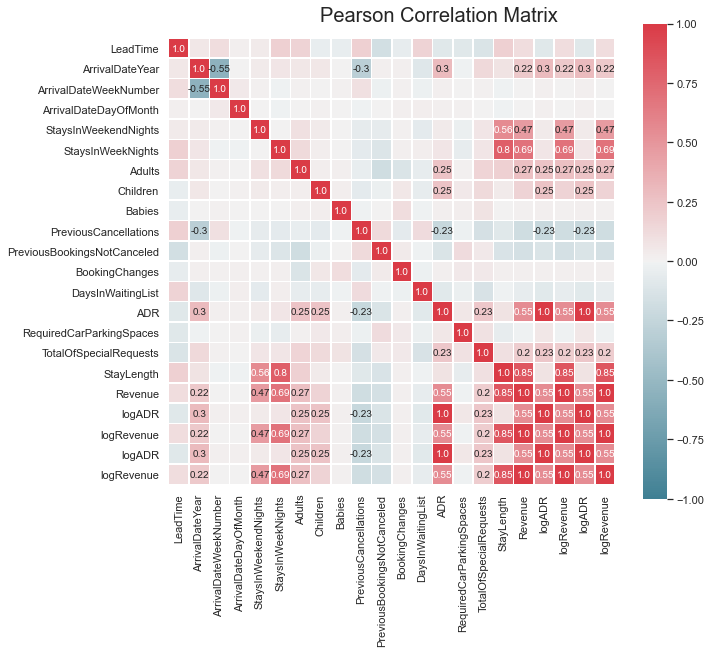

In [86]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = round(df[metric_features].corr(method="spearman"),2)

# Build annotation matrix (values above |0.2| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.2
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

In [75]:
#Almost all the features are not correlated
# There's a considerable correlation between 'StaysInWeekendNights' and 'logRevenue' althought it can be ignored

## Relevancy: 

### Correlation:

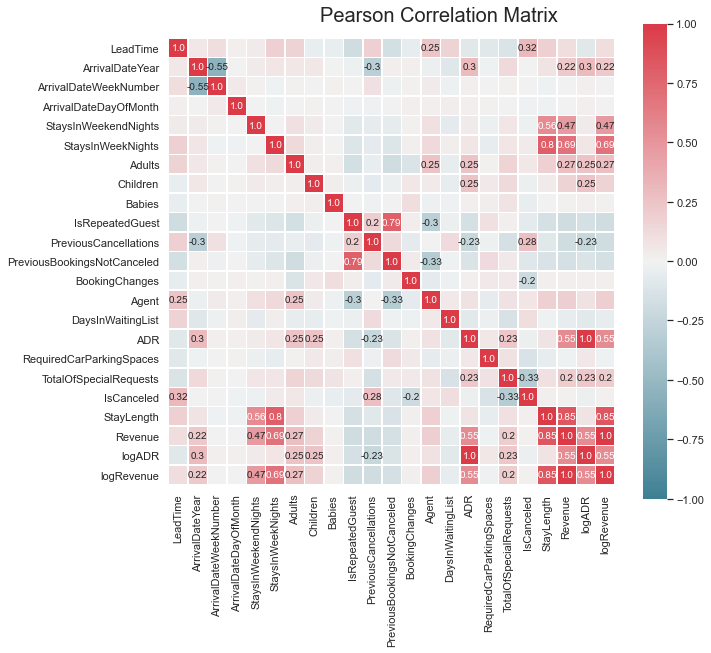

In [67]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = round(df.corr(method="spearman"),2)

# Build annotation matrix (values above |0.2| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.2
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

By checking the pearson correlation we can notice that the variables that have the biggest correlation with the canceling status are: LeadTime, PreviousCancellations (positive correlation) and TotalOfSpecialRequests, BookingChanges (negative correlation)

### RFE

In [77]:
#Resplitting the data for the wrapper and embedded methods

In [140]:
L=['ArrivalDateMonth','ADR', 'Revenue', 'logADR', 'logRevenue']
metric_features = [i for i in metric_features if i not in L]

In [141]:
metric_features

['LeadTime',
 'ArrivalDateYear',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests']

In [ ]:
I couldn't include these features, needs to be rechecked!

In [124]:
target = df['IsCanceled']
data = df.drop(['IsCanceled'], axis=1) 
X_train, X_val, y_train, y_val = train_test_split(data,target, test_size = 0.15, random_state = 0, stratify = target, shuffle = True)

In [125]:
### Determining the number of features to include: 
#no of features
nof_list=np.arange(1,11)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    train_rfe = rfe.fit_transform(X_train[metric_features],y_train)
    val_rfe = rfe.transform(X_val[metric_features])
    model.fit(train_rfe,y_train)
    
    score = model.score(val_rfe,y_val)
    score_list.append(score)
    
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 10
Score with 10 features: 0.725634


In [126]:
# Apply RFE with 10 features: 
rfe=RFE(estimator=model, n_features_to_select=10)
X_rfe= rfe.fit_transform(X=X_train[metric_features], y=y_train)
selected_features = pd.Series(rfe.support_, index = metric_features)
selected_features

LeadTime                       False
ArrivalDateYear                False
ArrivalDateWeekNumber           True
ArrivalDateDayOfMonth          False
StaysInWeekendNights           False
StaysInWeekNights               True
Adults                          True
Children                        True
Babies                          True
PreviousCancellations           True
PreviousBookingsNotCanceled     True
BookingChanges                  True
DaysInWaitingList              False
RequiredCarParkingSpaces        True
TotalOfSpecialRequests          True
dtype: bool

### Lasso

In [127]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [128]:
reg = LassoCV()
reg.fit(X_train[metric_features], y_train)
coef = pd.Series(reg.coef_, index = metric_features)
coef

LeadTime                       0.001231
ArrivalDateYear                0.000000
ArrivalDateWeekNumber         -0.001253
ArrivalDateDayOfMonth         -0.000262
StaysInWeekendNights           0.000000
StaysInWeekNights              0.009382
Adults                         0.000000
Children                       0.000000
Babies                        -0.000000
PreviousCancellations          0.052196
PreviousBookingsNotCanceled   -0.006711
BookingChanges                -0.057213
DaysInWaitingList             -0.000315
RequiredCarParkingSpaces      -0.000000
TotalOfSpecialRequests        -0.133391
dtype: float64

In [129]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 6 variables


In [130]:
coef.sort_values()

TotalOfSpecialRequests        -0.133391
BookingChanges                -0.057213
PreviousBookingsNotCanceled   -0.006711
ArrivalDateWeekNumber         -0.001253
DaysInWaitingList             -0.000315
ArrivalDateDayOfMonth         -0.000262
ArrivalDateYear                0.000000
StaysInWeekendNights           0.000000
Adults                         0.000000
Children                       0.000000
Babies                        -0.000000
RequiredCarParkingSpaces      -0.000000
LeadTime                       0.001231
StaysInWeekNights              0.009382
PreviousCancellations          0.052196
dtype: float64

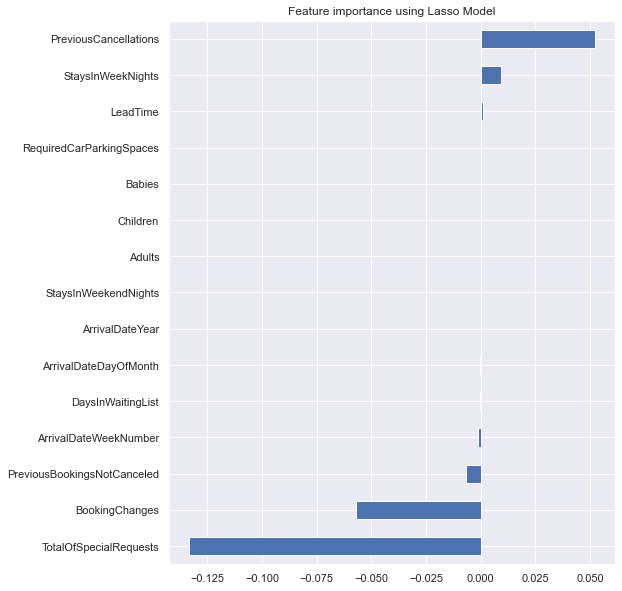

In [131]:
plot_importance(coef,'Lasso')

### Decision Tree importances: 

In [133]:
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X_train[metric_features], y_train)
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(metric_features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: LeadTime             Importance: 0.33
Variable: ArrivalDateDayOfMonth Importance: 0.13
Variable: TotalOfSpecialRequests Importance: 0.12
Variable: ArrivalDateWeekNumber Importance: 0.11
Variable: StaysInWeekNights    Importance: 0.07
Variable: BookingChanges       Importance: 0.05
Variable: ArrivalDateYear      Importance: 0.04
Variable: StaysInWeekendNights Importance: 0.04
Variable: PreviousCancellations Importance: 0.04
Variable: Adults               Importance: 0.03
Variable: Children             Importance: 0.01
Variable: PreviousBookingsNotCanceled Importance: 0.01
Variable: DaysInWaitingList    Importance: 0.01
Variable: RequiredCarParkingSpaces Importance: 0.01
Variable: Babies               Importance: 0.0


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

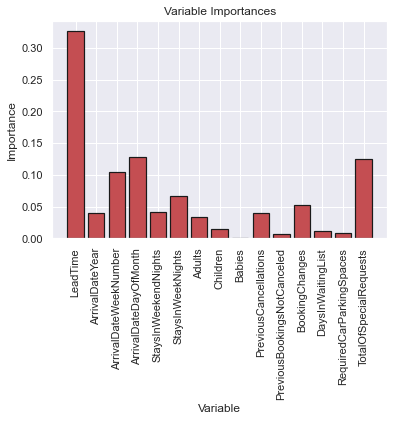

In [135]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, metric_features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### Chi-Square for categorical data

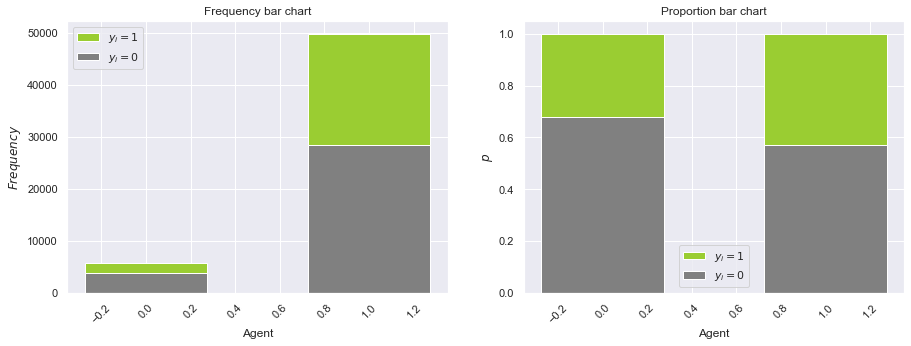

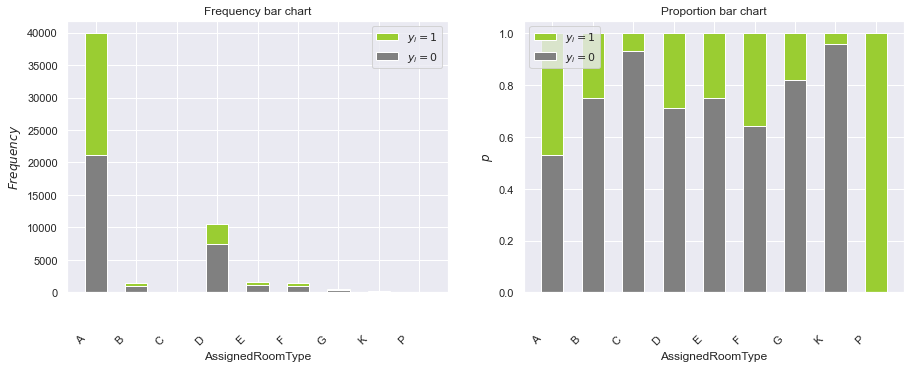

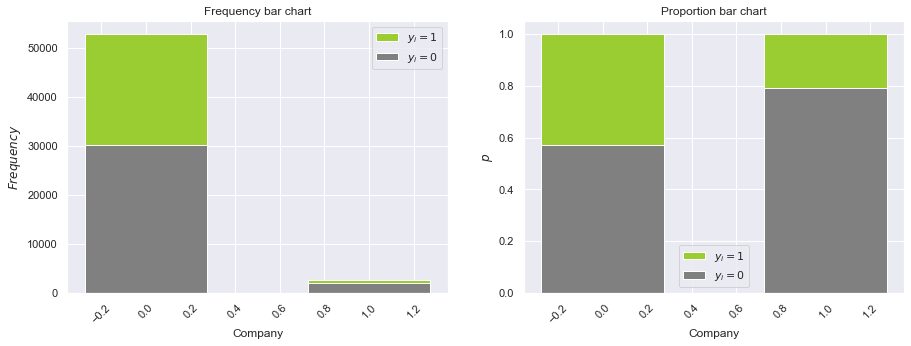

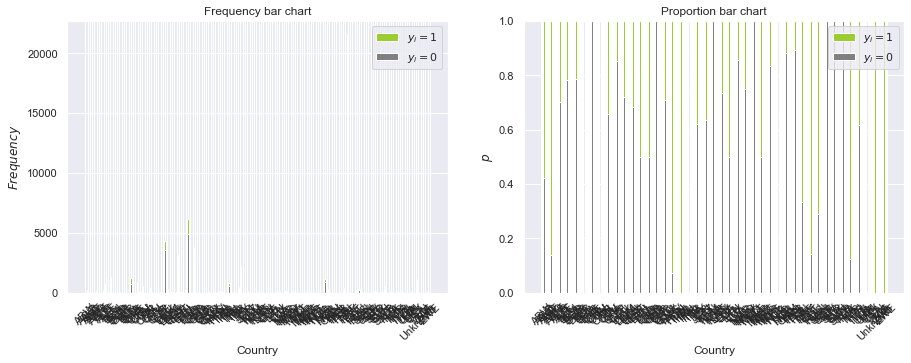

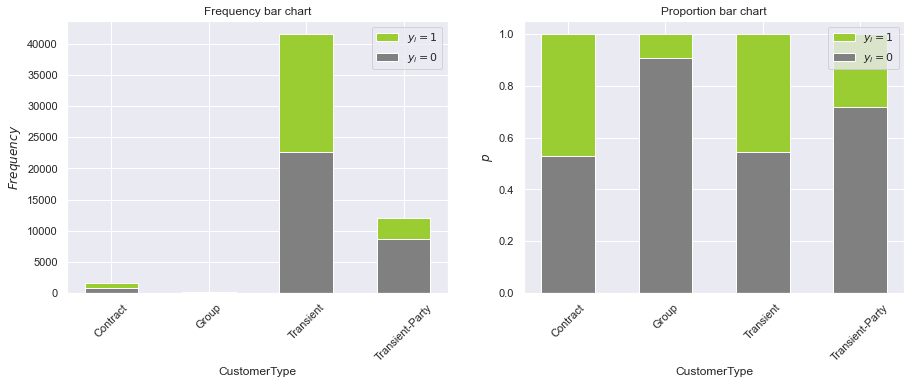

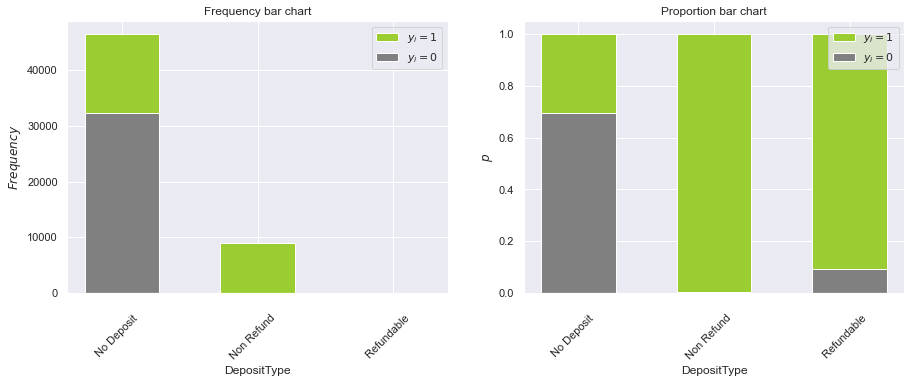

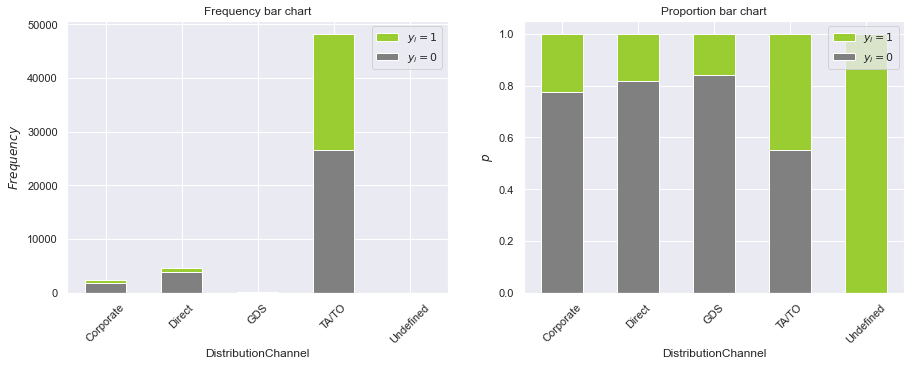

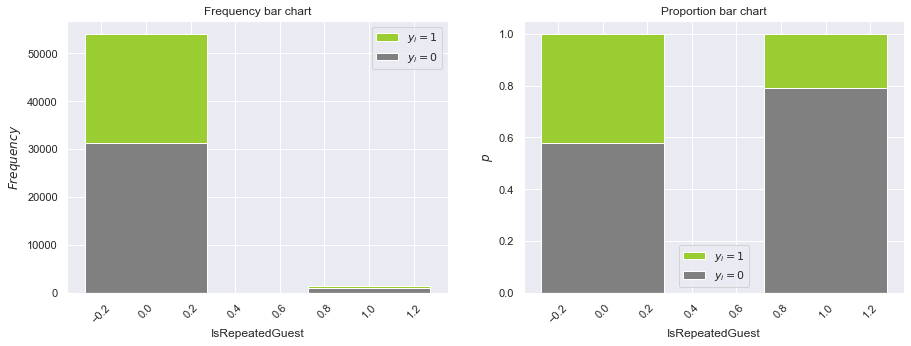

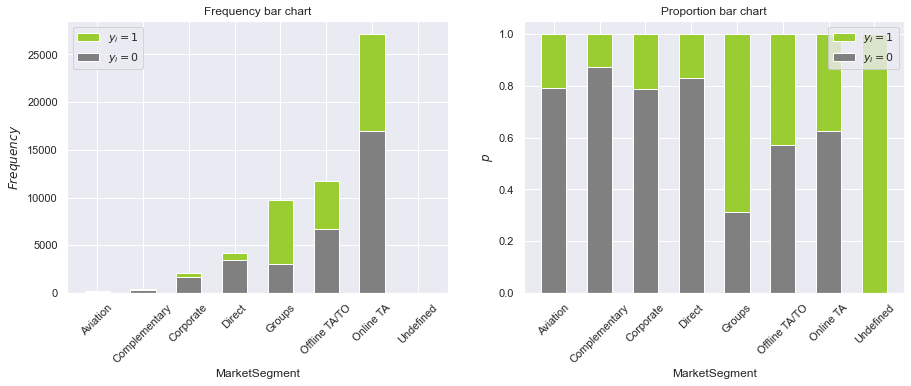

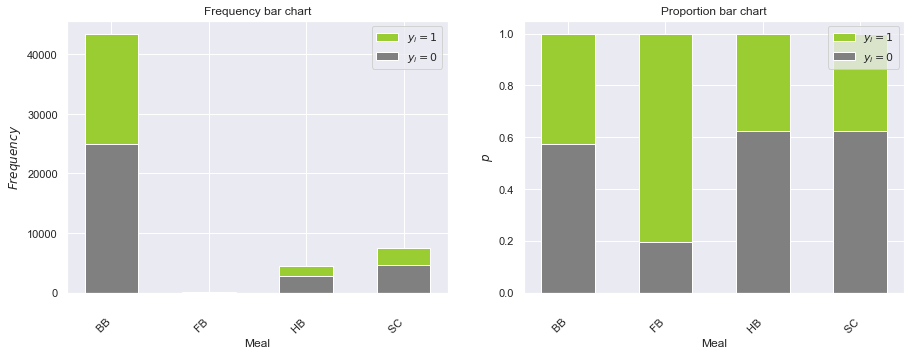

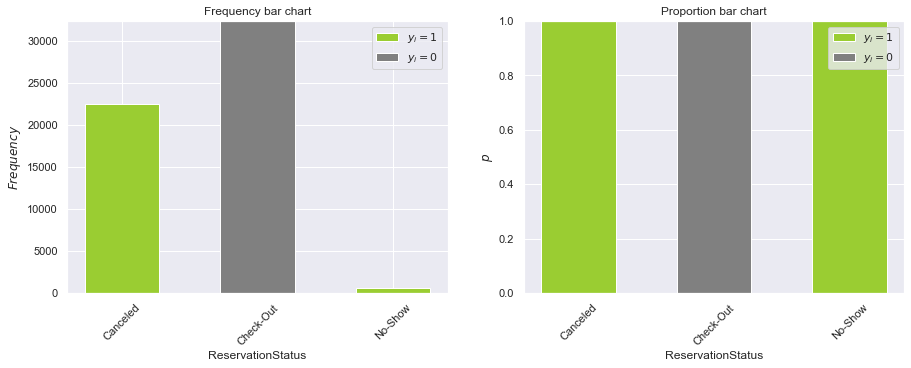

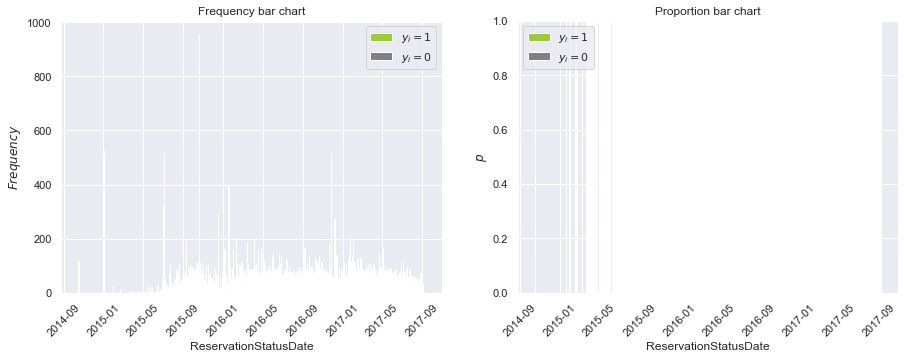

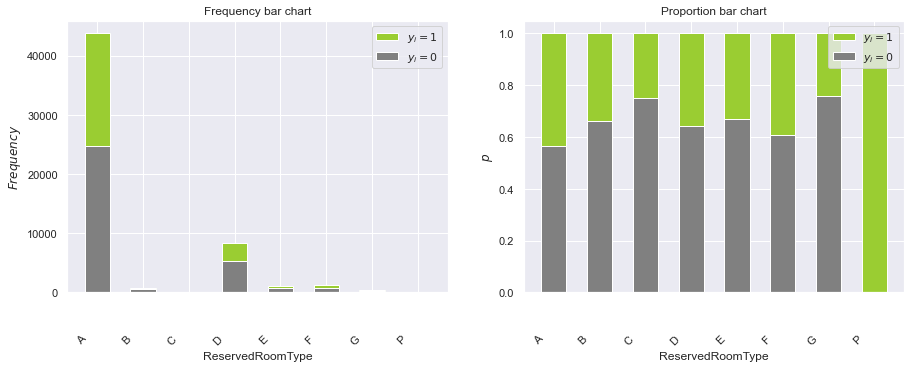

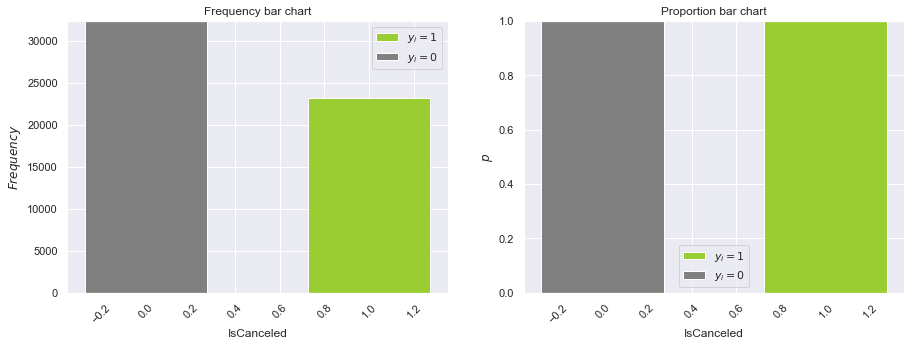

In [68]:
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins = True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.ylabel("$Frequency$")

   
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                         np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.xticks(rotation=45)
    plt.ylabel("$p$")

    plt.show()  
    
for i in range(len(df[non_metric_features].columns)):
     bar_charts_categorical(df=df[non_metric_features],target="IsCanceled",feature=df[non_metric_features].columns[i])

In [69]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [70]:
#Weird 

for var in df[non_metric_features_without_target]:
    TestIndependence(df[var],df['IsCanceled'], var)

Agent is IMPORTANT for Prediction
AssignedRoomType is IMPORTANT for Prediction
Company is IMPORTANT for Prediction
Country is IMPORTANT for Prediction
CustomerType is IMPORTANT for Prediction
DepositType is IMPORTANT for Prediction
DistributionChannel is IMPORTANT for Prediction
IsRepeatedGuest is IMPORTANT for Prediction
MarketSegment is IMPORTANT for Prediction
Meal is IMPORTANT for Prediction
ReservationStatus is IMPORTANT for Prediction
ReservationStatusDate is IMPORTANT for Prediction
ReservedRoomType is IMPORTANT for Prediction


In [ ]:
'''other considerations for ML algorithm
fairly balanced (41%)
should scale the data'''

In [ ]:
df.to_csv('cleaned_data.csv')